In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import matplotlib as mpl
import datetime as dt
import squarify
from sklearn.preprocessing import StandardScaler
import warnings
# current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import missingno as msno # missing data visualization module for Python
import pandas_profiling

import gc
import datetime

%matplotlib inline
color = sns.color_palette()
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
#
from sklearn.cluster import KMeans
#
import plotly.offline as pyo 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from feature_engine.outlier_removers import Winsorizer
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import plotly.express as px

In [2]:
#Import data file
df = pd.read_csv('assignment2_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433527 entries, 0 to 433526
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Orderno   433527 non-null  object 
 1   prodcode  433527 non-null  object 
 2   proddesc  432357 non-null  object 
 3   qty       433527 non-null  int64  
 4   date      433527 non-null  object 
 5   uprice    433527 non-null  float64
 6   custid    325290 non-null  float64
 7   country   433527 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 26.5+ MB


In [4]:
#Check percentage of missing data in the dataset
def missing_data(df):
    #Total=len(df.index)
    Missing = df.isnull().sum().sort_values(ascending=False)
    Percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([Missing ,Percent], axis=1, keys=['Missing','Missing %'])
    return missing_data
missing_data(df)

Missing  Missing %
custid     108237  24.966611
proddesc     1170   0.269879
country         0   0.000000
uprice          0   0.000000
date            0   0.000000
qty             0   0.000000
prodcode        0   0.000000
Orderno         0   0.000000

In [5]:
#Convert variables to the correct data format types

df['prodcode'] = df['prodcode'].astype('category')
df['proddesc'] = df['proddesc'].astype('category')
df['country'] = df['country'].astype('category')
df['custid'] = df['custid'].astype('object')
df.describe()

qty         uprice
count  433527.000000  433527.000000
mean        9.582148       4.660611
std       176.010575      96.904838
min    -74215.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   38970.000000

In [6]:
df_new = df.dropna()
df_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 325290 entries, 2 to 433526
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Orderno   325290 non-null  object  
 1   prodcode  325290 non-null  category
 2   proddesc  325290 non-null  category
 3   qty       325290 non-null  int64   
 4   date      325290 non-null  object  
 5   uprice    325290 non-null  float64 
 6   custid    325290 non-null  object  
 7   country   325290 non-null  category
dtypes: category(3), float64(1), int64(1), object(3)
memory usage: 16.8+ MB


In [7]:
df_new = df_new[ df_new.qty > 0]
df_new = df_new[df_new.uprice > 0]

In [8]:
print('Dupplicate entries: {}'.format(df_new.duplicated().sum()))
df_new.drop_duplicates(inplace = True)

Dupplicate entries: 3400


In [9]:
#the number of users and products in these entries

pd.DataFrame([{'Unique products': len(df_new['prodcode'].value_counts()),    
               'Transactions': len(df_new['Orderno'].value_counts()),
               'Unique Registered customers': len(df_new['custid'].value_counts()),  
              }], columns = ['Unique products', 'Transactions', 'Unique Registered customers'], index = ['quantity'])



Unique products  Transactions  Unique Registered customers
quantity             4023         18197                         4326

In [10]:
#Add the column - amount_spent
df_new['amount_spent'] = df_new['qty'] * df_new['uprice']

In [11]:
# rearrange all the columns for easy reference
df_new = df_new[['Orderno','date','prodcode','proddesc','qty','uprice','amount_spent','custid','country']]

In [12]:
df_new['date'] = to_datetime(df_new['date'])

In [13]:
num_order=df_new.groupby(by=['custid'], as_index=False)['Orderno'].nunique().head()

In [14]:
money_spent = df_new.groupby(by=['custid'], as_index=False)['amount_spent'].sum()

In [15]:
df_new['date_mod'] = df_new['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))

In [16]:
df_new['date_mod'] = pd.to_datetime(df_new['date_mod'], format='%Y-%m-%d') 

In [17]:
#group by customer by last date they purchased...
recency_df = df_new.groupby(['custid'],as_index=False)['date_mod'].max()
recency_df.columns = ['custid','LastPurchaseDate']
recency_df.head()

custid LastPurchaseDate
0  12347.0       2011-10-31
1  12348.0       2011-09-25
2  12349.0       2011-11-21
3  12350.0       2011-02-02
4  12352.0       2011-09-28

In [18]:
now = dt.datetime(2011,12,11)
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : ((now - x)*-1).days)

In [19]:
recency_df.sort_values('Recency')

custid LastPurchaseDate  Recency
4169  18074.0       2010-01-12     -698
354   12791.0       2010-01-12     -698
1035  13747.0       2010-01-12     -698
1389  14237.0       2010-01-12     -698
2709  16048.0       2010-01-12     -698
...       ...              ...      ...
553   13078.0       2011-12-10       -1
2046  15144.0       2011-12-10       -1
580   13115.0       2011-12-10       -1
2251  15421.0       2011-12-10       -1
4325  18287.0       2011-12-10       -1

[4326 rows x 3 columns]

In [20]:
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)

In [21]:
frequency_df = df_new.copy()
frequency_df.drop_duplicates(subset=['custid','Orderno'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('custid',as_index=False)['Orderno'].count()
frequency_df.columns = ['custid','Frequency']
frequency_df.head()

custid  Frequency
0  12347.0          7
1  12348.0          4
2  12349.0          1
3  12350.0          1
4  12352.0          8

In [22]:
monetary_df=df_new.groupby('custid',as_index=False)['amount_spent'].sum()
monetary_df.columns = ['custid','Monetary']
monetary_df.head()

custid  Monetary
0  12347.0   3538.84
1  12348.0   1343.04
2  12349.0   1500.17
3  12350.0    265.60
4  12352.0   1874.44

In [23]:
uniqprod_df=df_new.groupby('custid',as_index=False).prodcode.nunique()
uniqprod_df.columns = ['custid','Unique_Prod']
uniqprod_df.head()

custid  Unique_Prod
0  12347.0           92
1  12348.0           17
2  12349.0           60
3  12350.0           13
4  12352.0           46

In [24]:
avg_unitcost_df=df_new.groupby('custid',as_index=False)['amount_spent'].mean()
avg_unitcost_df.columns = ['custid','Average_Inv_Amt']
avg_unitcost_df.head()

custid  Average_Inv_Amt
0  12347.0        22.979481
1  12348.0        58.393043
2  12349.0        25.002833
3  12350.0        20.430769
4  12352.0        32.884912

In [25]:
avg_qty_df=df_new.groupby('custid',as_index=False)['qty'].mean()
avg_qty_df.columns = ['custid','Average_Qty']
avg_qty_df.describe()

custid   Average_Qty
count   4326.000000   4326.000000
mean   15299.543458     29.998190
std     1721.471229    624.245056
min    12347.000000      1.000000
25%    13812.250000      5.871765
50%    15298.500000      9.954951
75%    16777.750000     14.569432
max    18287.000000  40498.000000

In [26]:
#Combine all together all dataframe in so we have recency, frequency and monetary values together..

#combine first recency and frequency..
rf = recency_df.merge(frequency_df,left_on='custid',right_on='custid')

#combibe rf frame with monetary values..

rfm = rf.merge(monetary_df,left_on='custid',right_on='custid')

#combine uni.
rfm_a =rfm.merge(uniqprod_df,left_on='custid',right_on='custid')

#combibe rf frame with monetary values..

rfm_all = rfm_a.merge(avg_unitcost_df,left_on='custid',right_on='custid')

rfm_all_new =rfm_all.merge(avg_qty_df,left_on='custid',right_on='custid')

rfm_all_new.set_index('custid',inplace=True)

In [27]:
rfm_all_new.head()
rfm_all_new = rfm_all_new[rfm_all_new.Average_Qty > 0]

In [28]:
rfm_table= rfm_all_new.copy()
rfm_table.head()

Recency  Frequency  Monetary  Unique_Prod  Average_Inv_Amt  \
custid                                                                
12347.0      -41          7   3538.84           92        22.979481   
12348.0      -77          4   1343.04           17        58.393043   
12349.0      -20          1   1500.17           60        25.002833   
12350.0     -312          1    265.60           13        20.430769   
12352.0      -74          8   1874.44           46        32.884912   

         Average_Qty  
custid                
12347.0    12.402597  
12348.0    80.782609  
12349.0     9.183333  
12350.0    12.076923  
12352.0     6.491228

In [29]:
rfm_table.drop(columns=['Unique_Prod','Average_Inv_Amt','Average_Qty'],inplace=True)

In [30]:
rfm_table.head()
rfm_table.to_csv("rfm.csv")

In [31]:
def FScore(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4

quantiles = rfm_table.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
rfm_table['Freq_Tile'] = rfm_table['Frequency'].apply(FScore, args=('Frequency',quantiles,))

#Recency 
rfm_table = rfm_table.sort_values('Recency',ascending=True)
rfm_table['Rec_Tile'] = pd.qcut(rfm_table['Recency'],5,labels=False)

#Monetary 
rfm_table['Mone_Tile'] = pd.qcut(rfm_table['Monetary'],5,labels=False)

# instead of zero, plus 1 
rfm_table['Rec_Tile'] = rfm_table['Rec_Tile'] + 1
rfm_table['Freq_Tile'] = rfm_table['Freq_Tile'] + 1
rfm_table['Mone_Tile'] = rfm_table['Mone_Tile'] + 1

# Add to dataframe
rfm_table['RFM Score'] = rfm_table['Rec_Tile'].map(str) + rfm_table['Freq_Tile'].map(str) + rfm_table['Mone_Tile'].map(str)
rfm_table.head()

Recency  Frequency  Monetary  Freq_Tile  Rec_Tile  Mone_Tile  \
custid                                                                  
18074.0     -698          1     464.1          1         1          3   
12791.0     -698          1      15.0          1         1          1   
13747.0     -698          1      79.6          1         1          1   
14237.0     -698          1     109.4          1         1          1   
16048.0     -698          1     186.0          1         1          1   

        RFM Score  
custid             
18074.0       113  
12791.0       111  
13747.0       111  
14237.0       111  
16048.0       111

In [32]:
# Calculate RFM_Score
rfm_table['RFM_Sum'] = rfm_table[['Freq_Tile','Rec_Tile','Mone_Tile']].sum(axis=1)
rfm_table.head()

Recency  Frequency  Monetary  Freq_Tile  Rec_Tile  Mone_Tile  \
custid                                                                  
18074.0     -698          1     464.1          1         1          3   
12791.0     -698          1      15.0          1         1          1   
13747.0     -698          1      79.6          1         1          1   
14237.0     -698          1     109.4          1         1          1   
16048.0     -698          1     186.0          1         1          1   

        RFM Score  RFM_Sum  
custid                      
18074.0       113        5  
12791.0       111        3  
13747.0       111        3  
14237.0       111        3  
16048.0       111        3

In [33]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Sum'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Champions'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Potential'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Promising'
    elif ((df['RFM_Sum'] >= 4) and (df['RFM_Sum'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm_table['RFM_Level'] = rfm_table.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm_table.head()

Recency  Frequency  Monetary  Freq_Tile  Rec_Tile  Mone_Tile  \
custid                                                                  
18074.0     -698          1     464.1          1         1          3   
12791.0     -698          1      15.0          1         1          1   
13747.0     -698          1      79.6          1         1          1   
14237.0     -698          1     109.4          1         1          1   
16048.0     -698          1     186.0          1         1          1   

        RFM Score  RFM_Sum           RFM_Level  
custid                                          
18074.0       113        5           Promising  
12791.0       111        3  Require Activation  
13747.0       111        3  Require Activation  
14237.0       111        3  Require Activation  
16048.0       111        3  Require Activation

In [34]:
rfm_table["RFM_Level"].value_counts()

Can't Loose Them      2097
Potential              424
Needs Attention        405
Loyal                  387
Promising              385
Require Activation     322
Champions              306
Name: RFM_Level, dtype: int64

In [35]:
rfm_level_agg = rfm_table.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them     -41.3       7.2   3017.0  2097
Champions            -83.0       2.1    636.1   306
Loyal                -92.0       1.7    438.2   387
Needs Attention     -241.7       1.1    197.4   405
Potential           -123.1       1.4    356.1   424
Promising           -166.3       1.2    263.2   385
Require Activation  -311.7       1.0    112.4   322


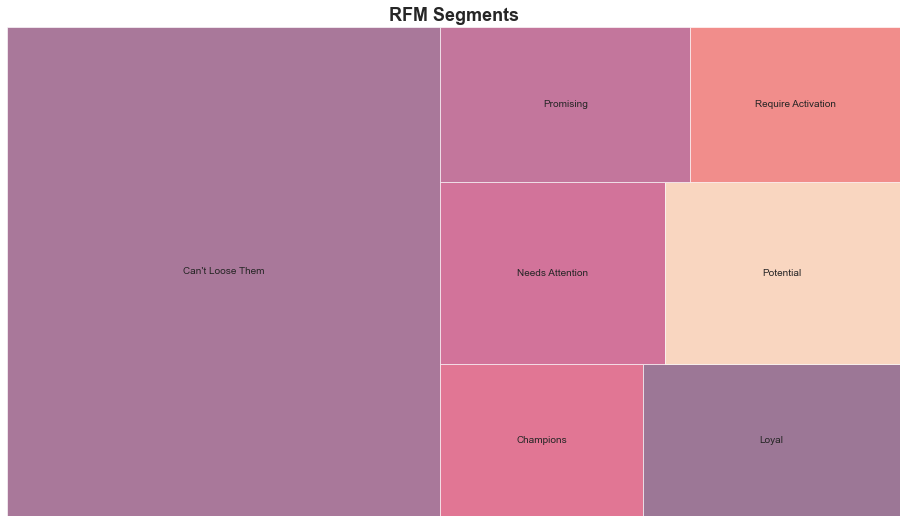

In [36]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# K-Mean Clustering

In [37]:
clustering_fm = rfm_all_new[['Recency',"Frequency","Monetary","Unique_Prod","Average_Inv_Amt","Average_Qty"]].copy()
clustering_fm['Recency'] = clustering_fm['Recency'].apply(lambda x: x*-1)
clustering_fm.to_csv("RFM_ALL.csv")

clustering_fm.head()

Recency  Frequency  Monetary  Unique_Prod  Average_Inv_Amt  \
custid                                                                
12347.0       41          7   3538.84           92        22.979481   
12348.0       77          4   1343.04           17        58.393043   
12349.0       20          1   1500.17           60        25.002833   
12350.0      312          1    265.60           13        20.430769   
12352.0       74          8   1874.44           46        32.884912   

         Average_Qty  
custid                
12347.0    12.402597  
12348.0    80.782609  
12349.0     9.183333  
12350.0    12.076923  
12352.0     6.491228

In [38]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.9271621670880232, : SkewtestResult(statistic=35.04691030024648, pvalue=4.3454873479834714e-269)
Frequency's: Skew: 12.15119835466742, : SkewtestResult(statistic=74.68517550479963, pvalue=0.0)
Monetary's: Skew: 20.145182712499345, : SkewtestResult(statistic=85.80076828057402, pvalue=0.0)
Average_Inv_Amt's: Skew: 65.01899301155099, : SkewtestResult(statistic=111.59258407612545, pvalue=0.0)
Average_Qty's: Skew: 63.11914074841432, : SkewtestResult(statistic=110.93965462384139, pvalue=0.0)
Unique_Prod's: Skew: 7.5893286448674, : SkewtestResult(statistic=64.35997634237724, pvalue=0.0)


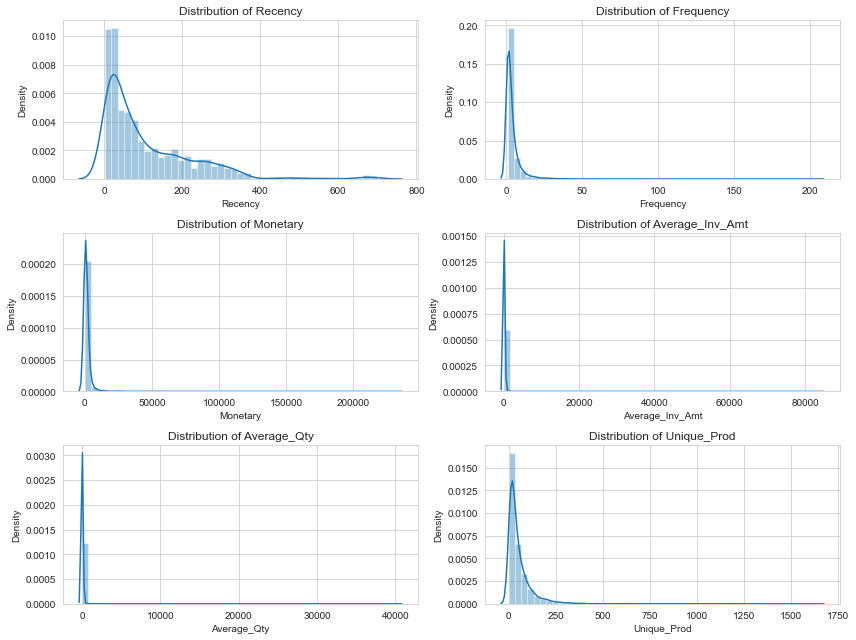

In [39]:

plt.figure(figsize=(12, 9))

plt.subplot(3, 2, 1)
check_skew(clustering_fm,'Recency')

plt.subplot(3, 2, 2)
check_skew(clustering_fm,'Frequency')

plt.subplot(3, 2, 3)
check_skew(clustering_fm,'Monetary')

plt.subplot(3, 2, 4)
check_skew(clustering_fm,'Average_Inv_Amt')

plt.subplot(3, 2, 5)
check_skew(clustering_fm,'Average_Qty')

plt.subplot(3, 2, 6)
check_skew(clustering_fm,'Unique_Prod')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

In [40]:
df_rfm_log = clustering_fm.copy()

Recency's: Skew: 1.9271621670880232, : SkewtestResult(statistic=35.04691030024648, pvalue=4.3454873479834714e-269)
Frequency's: Skew: 12.15119835466742, : SkewtestResult(statistic=74.68517550479963, pvalue=0.0)
Monetary's: Skew: 20.145182712499345, : SkewtestResult(statistic=85.80076828057402, pvalue=0.0)
Average_Inv_Amt's: Skew: 65.01899301155099, : SkewtestResult(statistic=111.59258407612545, pvalue=0.0)
Average_Qty's: Skew: 63.11914074841432, : SkewtestResult(statistic=110.93965462384139, pvalue=0.0)
Unique_Prod's: Skew: 7.5893286448674, : SkewtestResult(statistic=64.35997634237724, pvalue=0.0)


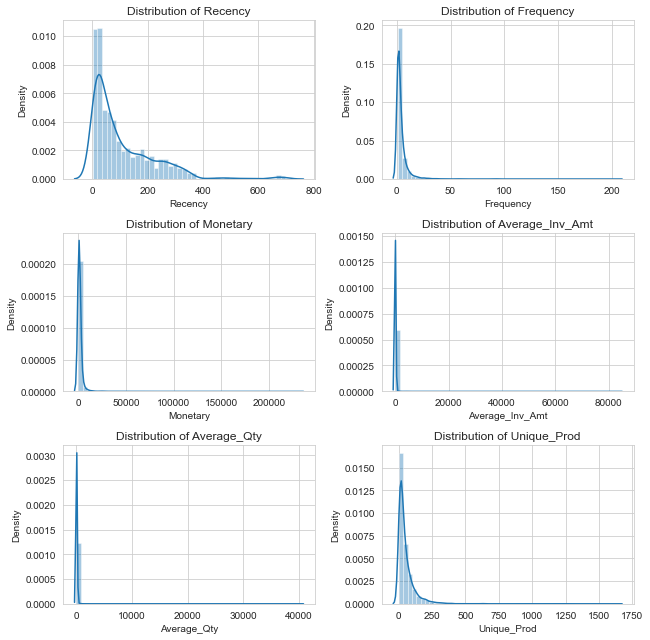

In [41]:
df_rfm_log = np.log(df_rfm_log+100)

plt.figure(figsize=(9, 9))

plt.subplot(3, 2, 1)
check_skew(clustering_fm,'Recency')

plt.subplot(3, 2, 2)
check_skew(clustering_fm,'Frequency')

plt.subplot(3, 2, 3)
check_skew(clustering_fm,'Monetary')

plt.subplot(3, 2, 4)
check_skew(clustering_fm,'Average_Inv_Amt')

plt.subplot(3, 2, 5)
check_skew(clustering_fm,'Average_Qty')

plt.subplot(3, 2, 6)
check_skew(clustering_fm,'Unique_Prod')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

In [44]:
#df_rfm_log = df_rfm_log.dropna()
windsoriser = Winsorizer(distribution='skewed', 
                          tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary','Average_Inv_Amt','Average_Qty','Unique_Prod']
                        )

windsoriser.fit(df_rfm_log)

Winsorizer(distribution='skewed', fold=2, tail='both',
           variables=['Recency', 'Frequency', 'Monetary', 'Average_Inv_Amt',
                      'Average_Qty', 'Unique_Prod'])

In [45]:
df_rfm_log = windsoriser.transform(df_rfm_log)

In [46]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [47]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)

Recency's: Skew: 0.7325729819561799, : SkewtestResult(statistic=17.72672285831559, pvalue=2.6079979468822017e-70)
Frequency's: Skew: 1.5846085125842335, : SkewtestResult(statistic=31.14613321234388, pvalue=5.721941171854315e-213)
Monetary's: Skew: 0.7324648924185104, : SkewtestResult(statistic=17.724556258189587, pvalue=2.7104337935763235e-70)
Average_Inv_Amt's: Skew: 0.99703118819586, : SkewtestResult(statistic=22.622579288074967, pvalue=2.5983700269745365e-113)
Average_Qty's: Skew: 1.1598864998157938, : SkewtestResult(statistic=25.272485021276154, pvalue=6.41206470851475e-141)
Unique_Prod's: Skew: 1.2276728473581628, : SkewtestResult(statistic=26.3037361128115, pvalue=1.7379824195761552e-152)


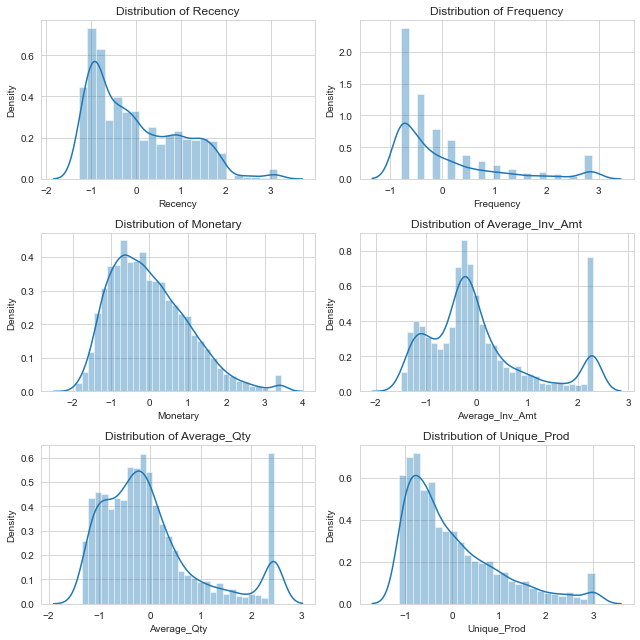

In [50]:


plt.figure(figsize=(9, 9))

plt.subplot(3, 2, 1)
check_skew(RFM_Table_scaled,'Recency')

plt.subplot(3, 2, 2)
check_skew(RFM_Table_scaled,'Frequency')

plt.subplot(3, 2, 3)
check_skew(RFM_Table_scaled,'Monetary')

plt.subplot(3, 2, 4)
check_skew(RFM_Table_scaled,'Average_Inv_Amt')

plt.subplot(3, 2, 5)
check_skew(RFM_Table_scaled,'Average_Qty')

plt.subplot(3, 2, 6)
check_skew(RFM_Table_scaled,'Unique_Prod')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

In [51]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

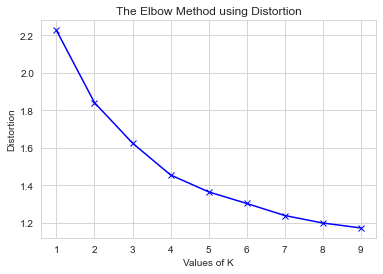

In [52]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

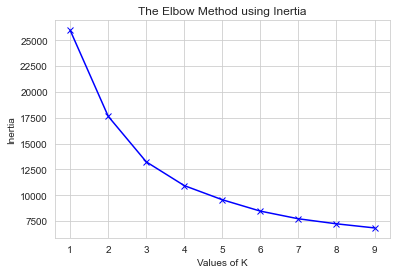

In [53]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [54]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

In [55]:
RFM_Table=clustering_fm

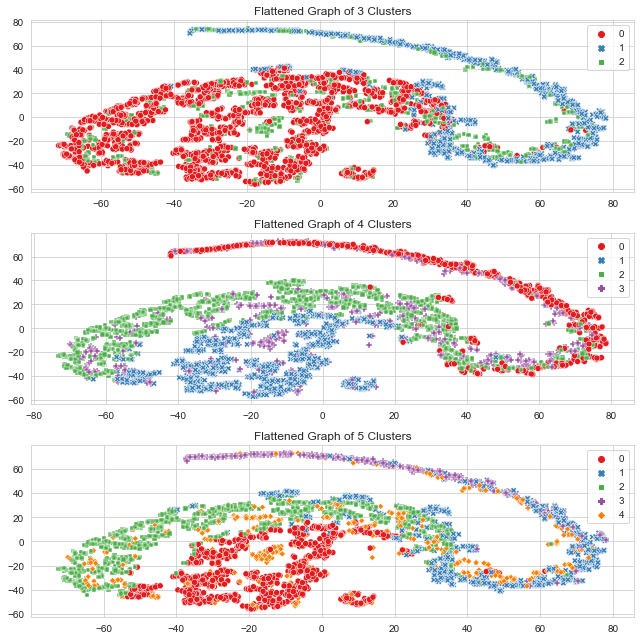

In [56]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

In [57]:

def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary':'mean',
        'Average_Inv_Amt':'mean',
        'Average_Qty':'mean',
        'Unique_Prod':['mean', 'count']
        
    }).round(0)
    
    return df_new

In [58]:
df_rfm_k4_mean=rfm_values(df_rfm_k4)
df_rfm_k4_mean.to_csv("df_rfm_k4_mean.csv")
df_rfm_k4_mean.head()

Recency Frequency Monetary Average_Inv_Amt Average_Qty Unique_Prod  \
           mean      mean     mean            mean        mean        mean   
Cluster                                                                      
0          33.0      12.0   5400.0            24.0        13.0       147.0   
1         241.0       1.0    279.0            18.0         8.0        21.0   
2          49.0       3.0    634.0            18.0         9.0        41.0   
3         106.0       3.0   2019.0           256.0       153.0        15.0   

               
        count  
Cluster        
0         817  
1        1187  
2        1713  
3         609

In [59]:
df_rfm_k4.to_csv("Clustering.csv")

In [60]:
# Normalize the data sets for Parallel 
data_sets=df_rfm_k4.copy()

import pandas as pd
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

dfTest = data_sets

dfTest[['Recency', 'Frequency','Monetary','Unique_Prod','Average_Inv_Amt','Average_Qty']] = scaler.fit_transform(dfTest[['Recency', 'Frequency','Monetary','Unique_Prod','Average_Inv_Amt','Average_Qty']])


In [61]:

fig = px.parallel_coordinates(df_rfm_k4, color="Cluster", 
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

In [62]:
#df_rfm_k4
df_final=df.copy()  
df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433527 entries, 0 to 433526
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Orderno   433527 non-null  object  
 1   prodcode  433527 non-null  category
 2   proddesc  432357 non-null  category
 3   qty       433527 non-null  int64   
 4   date      433527 non-null  object  
 5   uprice    433527 non-null  float64 
 6   custid    325290 non-null  object  
 7   country   433527 non-null  category
dtypes: category(3), float64(1), int64(1), object(3)
memory usage: 19.0+ MB


In [63]:
df_final['date'] = to_datetime(df_final['date'])
df_final['date_mod'] = df_final['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
df_final['date_mod'] = pd.to_datetime(df_final['date_mod'], format='%Y-%m-%d')

In [64]:
df_complete = pd.merge(df_final, df_rfm_k4, on='custid', how='left')

In [65]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433527 entries, 0 to 433526
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Orderno          433527 non-null  object        
 1   prodcode         433527 non-null  category      
 2   proddesc         432357 non-null  category      
 3   qty              433527 non-null  int64         
 4   date             433527 non-null  datetime64[ns]
 5   uprice           433527 non-null  float64       
 6   custid           325290 non-null  object        
 7   country          433527 non-null  category      
 8   date_mod         433527 non-null  datetime64[ns]
 9   Recency          325218 non-null  float64       
 10  Frequency        325218 non-null  float64       
 11  Monetary         325218 non-null  float64       
 12  Unique_Prod      325218 non-null  float64       
 13  Average_Inv_Amt  325218 non-null  float64       
 14  Average_Qty      325

In [66]:
df_complete.to_csv("df_complete.csv")